# Data loading, VaR calculating, Controller execution

In [164]:
import json

config = json.loads(open ('config.json', "r").read())

In [165]:
from data_collecting import klines
data = klines(market = config['market'], tick_interval = config['tick_interval'], startDay = config['startDay'], endDay = config['endDay'])

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Returns')

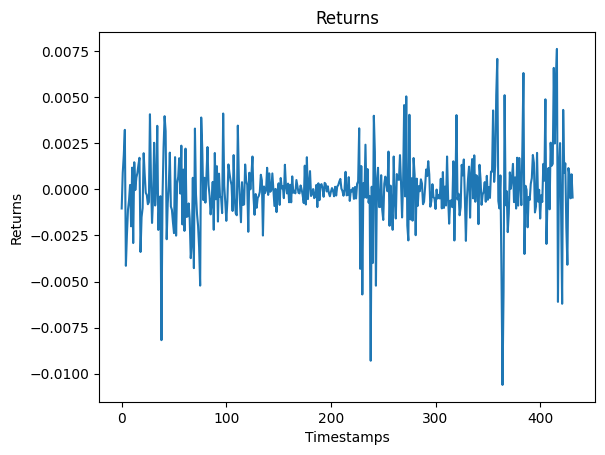

In [166]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.xlabel('Timestamps')
plt.ylabel('Returns')
plt.title('Returns')

In [167]:
from arima_garch import rolling_arima_garch
mean, variance, Value_at_risk, nu = rolling_arima_garch(data, window_size=config['window_size'], refit_every=config['refit_every'],  prediction_horizon=config['prediction_horizon'], p=config['p'], q=config['q'])

  0%|          | 0/385 [00:00<?, ?it/s]

In [168]:
from scipy.stats import t
target_VaR = config['target_VaR']
def running_objective(state, action, i):
    return 10**config['weight_of_VaR_target']*(action*(state[0]+state[1]*t.ppf(0.05, nu[i-config['window_size']]))- target_VaR)**2 + 0.05*(action - state[2])**2

In [169]:
from utils import SciPyOptimizer
from actor import ControllerMPC
import numpy as np
from tqdm.notebook import tqdm

optimizer = SciPyOptimizer(
    opt_options={
        "maxiter": 100,
        "disp": False,
    },
    opt_method="SLSQP"
)

def control(i):
    
    controller = ControllerMPC(
        i,
        data,
        mean = mean,
        variance = variance,
        optimizer = optimizer,
        running_objective=running_objective,
        action_bounds=np.array([[0, 100]]), 
        prediction_horizon = config['prediction_horizon'],
        discount_factor = config['discount_factor']
    )
    action = controller.compute_action()
    return action
data.loc[config['window_size']-1, 'Volume'] = 0.0
for i in tqdm(range(config['window_size']-1, len(data)-1)):
    action = control(i)
    data.loc[i, 'VaR'] = Value_at_risk.loc[i][0]
    data.loc[i, 'action'] = action
    data.loc[i+1, 'Volume'] = action*(1+data.loc[i+1, 'returns'])/((1-action)+action*(1+data.loc[i+1, 'returns']))

  0%|          | 0/384 [00:00<?, ?it/s]

# Comparing different approaches with backtesting

## Portfolio without any adjustments to risks

In [170]:
from metrics import Backtest
backtest = Backtest(data.returns[config['window_size']:].reset_index(drop = True), data.VaR[config['window_size']-1:-1].reset_index(drop = True)*0-0.003, 0.05)

In [171]:
backtest.Christoffersen_test()

,Statistic,p-value
Unconditional,0.576345,0.447749
Independence,5.109185,0.023799
Conditional,5.685530,0.058264


Hypothesis on independence of hits is rejected, so obviously VaR is targeted unsuccessfuly

In [172]:
backtest.losses()

,Losses
Hit rate,0.041667
Tick loss,0.000247
Smooth loss,-0.001267
Quadratic loss,0.041667
Firm loss,0.044542


## Portfolio with controller

In [173]:
backtest = Backtest(data.returns[config['window_size']:].reset_index(drop = True)*data.action[config['window_size']-1:-1].reset_index(drop = True),data.VaR[config['window_size']-1:-1].reset_index(drop = True)*0-0.003, 0.05)

In [174]:
backtest.losses()

,Losses
Hit rate,0.031250
Tick loss,0.000216
Smooth loss,-0.001283
Quadratic loss,0.031250
Firm loss,0.034157


In [175]:
backtest.Christoffersen_test()

,Statistic,p-value
Unconditional,3.222087,0.072651
Independence,0.777716,0.377840
Conditional,3.999804,0.135349


Losses are relatively low and all hypothesis are not rejected, hence constant VaR is targeted successfully

## Risk-parity portfolio - a perfectly elastic portfolio regardless of transaction costs

In [176]:
for i in tqdm(range(config['window_size']-1, len(data)-1)):
    action = config['target_VaR']/data.loc[i, 'VaR']
    data.loc[i, 'sharp_action'] = action
    data.loc[i+1, 'sharp_Volume'] = action*(1+data.loc[i+1, 'returns'])/((1-action)+action*(1+data.loc[i+1, 'returns']))

  0%|          | 0/384 [00:00<?, ?it/s]

In [177]:
backtest = Backtest(data.returns[config['window_size']:].reset_index(drop = True)*data.sharp_action[config['window_size']-1:-1].reset_index(drop = True),data.VaR[config['window_size']-1:-1].reset_index(drop = True)*0-0.003, 0.05)

In [178]:
backtest.losses()

,Losses
Hit rate,0.031250
Tick loss,0.000216
Smooth loss,-0.001293
Quadratic loss,0.031250
Firm loss,0.034157


In [179]:
backtest.Christoffersen_test()

,Statistic,p-value
Unconditional,3.222087,0.072651
Independence,0.777716,0.377840
Conditional,3.999804,0.135349


# Compare of resulting PnL, VaR, volumes

Text(0, 0.5, 'PnL')

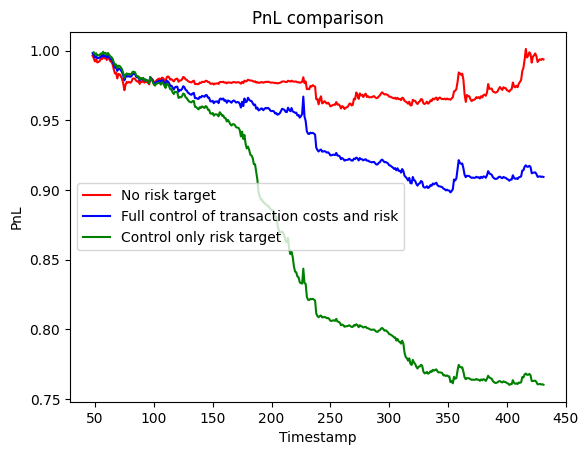

In [180]:
data['pnl'] = (1+data.returns[config['window_size']:]-(data.index[config['window_size']:] ==48)*0.0025).cumprod()
data['pnl_actor'] = (1 + data.action.shift(1)[config['window_size']:] *data.returns[config['window_size']:] - 0.0025*abs(data.Volume.shift(1)[config['window_size']:] - data.action.shift(1)[config['window_size']:])).cumprod()
data['pnl_parity'] = (1 + data.sharp_action.shift(1)[config['window_size']:] *data.returns[config['window_size']:] - 0.0025*abs(data.sharp_Volume.shift(1)[config['window_size']:] - data.sharp_action.shift(1)[config['window_size']:])).cumprod()
plt.plot(data.pnl, c = 'r',label ='No risk target')
plt.plot(data.pnl_actor,c = 'b', label = 'Full control of transaction costs and risk')
plt.plot(data.pnl_parity, c = 'g',label = 'Control only risk target')
plt.title('PnL comparison')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('PnL')

Controller allows to save some money from transactions costs 

Text(0, 0.5, 'VaR')

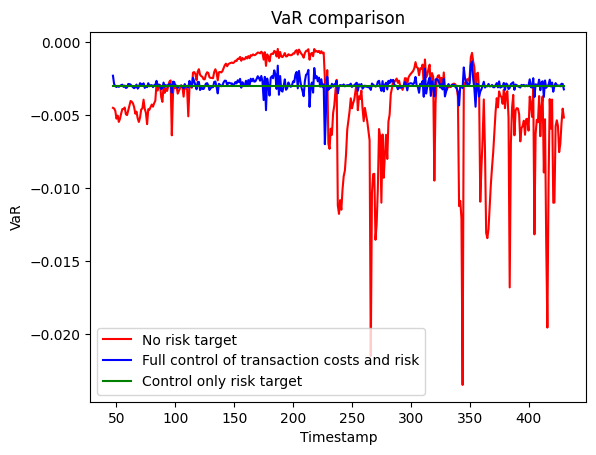

In [181]:
plt.plot(data.VaR, c = 'r', label ='No risk target')
plt.plot(data.VaR*data.action, c = 'b',label = 'Full control of transaction costs and risk')
plt.plot(data.VaR*data.sharp_action, c = 'g',label = 'Control only risk target')
plt.title('VaR comparison')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('VaR')

Controller alows to deviate from target in case of big transaction costs expecattions

Text(0, 0.5, 'Volume')

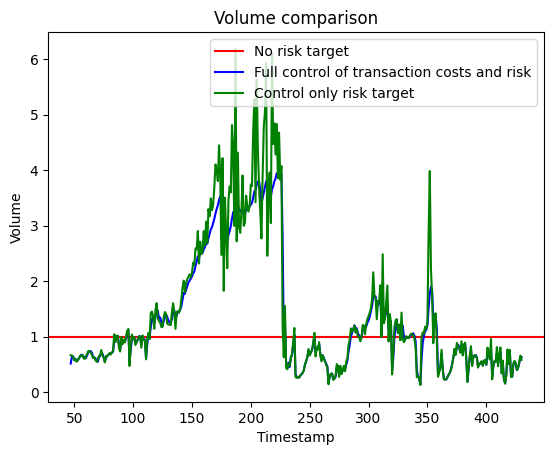

In [182]:
plt.axhline(y=1, c = 'r',label ='No risk target')
plt.plot(data.action,c = 'b', label = 'Full control of transaction costs and risk')
plt.plot(data.sharp_action, c = 'g',label = 'Control only risk target')
plt.title('Volume comparison')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Volume')

It can be seen that controller smoothed the changes in portfolio weights, so it fullfilled its goal